In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='monokai')

In [2]:
#export 
from exp.nb_2 import *

In [3]:
?PianorollDataset

In [4]:
# Good, let's re-create our datasets
path = os.path.abspath('/home/marco/workspace/musical-genre-from-pianorolls/piano_rolls')
train_ds = PianorollDataset(csv_file='train_valid.csv',base_path=path)
valid_ds = PianorollDataset(csv_file='train_valid.csv',base_path=path,valid_set=True)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True, num_workers=4)

In [5]:
# Let's understand how the Conv1D module works
?nn.Conv1d

In [6]:
# let's init the GPU device
device = torch.device('cuda')

In [7]:
# take one batch to test
x,y = next(iter(train_dl))
x,y = x.to(device),y.to(device)
# create a layer
layer = nn.Conv1d(in_channels=128,out_channels=32,kernel_size=3,stride=2).to(device)

The Conv1d will act on the outmost dimension of the input tensor.
`layer` expects an input with `batch_size x in_channels x seq_length` and returns an output with size `batch_size x out_channels x seq_length_prime` with `seq_length_prime` depending on the kernel size, padding and stride.

Note that `in_channels` in our case are the `128` MIDI pitches, NOT THE 5 "channels" of the stacked piano rolls!

So it's clear sadly that we won't be able to support all the 5 channels out of the box with Conv1d, let's verify it...

In [8]:
# pass the input through (first time this cell might take a moment to init your local GPU if not running on colab)
single_instrument_x = x[:,0,:,:].squeeze(1).float()
out = layer(single_instrument_x)
x.shape,single_instrument_x.shape,out.shape

(torch.Size([4, 5, 128, 10000]),
 torch.Size([4, 128, 10000]),
 torch.Size([4, 32, 4999]))

If we thus want to process the piano roll purely sequentially we only have 2 choices, either:
 * we use a Conv2d, with a kernel size of (128,3) to mimick what we just did but allowing for more than one input channel
 * we use a Conv1d on each instrument and seprately run a "Pointwise Convolution" on the outputs, mimicking [Depthwise Separable Convolutions](https://ikhlestov.github.io/pages/machine-learning/convolutions-types/#depthwise-separable-convolutions), popularized in the [MobileNet paper](https://arxiv.org/abs/1704.04861)
 
Both have their advantages in our context ( other than the obvious more parameters/flexibilty VS scalability):
I think that it makes sense to 'process' each instrument separately (maybe even for multiple layers) and then combine them using point-wise convolutions, so that we can analyze patterns for each of them and then see how they interact .. also this choice preserves absolute informations about pitches! Their lower dimensionality / higher speed will also help of course.

If we instead use a 2d convolution, we'll have to use a kernel size of (128,x) if we want to prevent erasing pitches informations from the piano roll, because otherwise the kernel will be shifted across the 'pitch dimension' as well and (because of the spacial invariance property) we'll lose that part of the musical information.

.. but, wait a second. Assume we have by mistake MIDIs of the same song, but performed in two different keys. Everything is the same but one song is in Eb and the other is in C. If we process the pianoroll 'purely sequentially', given the same weights, we will obtain two different representation of the two songs, while clearly their genre should match (they're the same song afterall!). So maybe using 2d convolutions is not so far-fetched!

Assuming we use 2d kernels with kernel_sizes that are smaller than 128 in the pitch dimension, what would it make sense to use? To cover a decent range of patterns across different instruments we could think about using 12 x \* kernels (12 is the number of pithces in an octave) and a kernel size of \* x 8 would make sense to capture patterns across one bar.

There are two main issue with this thinking though. 

The first is assuming we'd be dealing with the full tensors at both train and inference time. We now know that, especially during training time, the winning strategy in ImageNet is to crop the starting image down to 8% of the original size! 
[Reference "Going deeper with convolutions", Christian Szegedy et. al.](https://arxiv.org/abs/1409.4842)

Quoting from the paper:
> .., one prescription that was verified to work very well after the competition includes sampling
of various sized patches of the image whose size is distributed evenly between 8% and 100% of the
image area and whose aspect ratio is chosen randomly between 3/4 and 4/3. "

Meaning that regardless of our starting tensor, we will be be using only a random sub-crop of it!
Probably using the `PIL` method `img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)` ... 

Secondly, the [Bag of Tricks paper](https://arxiv.org/abs/1812.01187) suggest using multiple 3x3 kernels at the stem rather than bigger convolutions (like the 12x8 suggested above)!

In [9]:
# let's verify first that we can use a Conv2d on the whole b x 5 x 128 x seq_length input tensor
layer = nn.Conv2d(in_channels=5,out_channels=16,kernel_size=(12,16),stride=(4,6)).to(device)
out = layer(x.float()) # it'll become clear why we're not converting to float() directly in the DataSet in a second...
x.shape,out.shape

(torch.Size([4, 5, 128, 10000]), torch.Size([4, 16, 30, 1665]))

In [10]:
print( f'expected out size for pitches dimension = {int((128-12)/4+1)}' )
print( f'expected out size for seq_length dimension = {int((10000-8)/4+1)}' )
#check

expected out size for pitches dimension = 30
expected out size for seq_length dimension = 2499


In [11]:
# even after a few layers the dimension is quite high!
a,b = 128,10000
a,b = (a-12)/4+1 , int((b-16)/8+1)
a,b = (a-6)/2+1 , int((b-6)/3+1)
a,b = (a-3)/1+1 , int((b-3)/2+1)
a*b*64, 128*10000*5, a, b, nn.ReLU

(145728.0, 6400000, 11.0, 207, torch.nn.modules.activation.ReLU)

As shown above though the dimension of the first hidden layer, even with this very aggressive kernel size and stride is very high! So we'll probably have to think a bit more about data augmentation techniques before we can move on to our model.

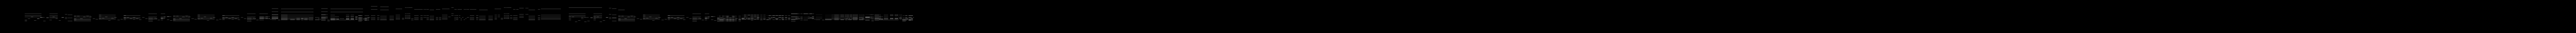

In [34]:
#Let's grab a tensor to explain a bit what's happening
import PIL
from torchvision import transforms

img = x[0].sum(dim=0,dtype=torch.uint8).cpu() # need to move it to CPU for PIL
img = transforms.ToPILImage()(img)
display(img)


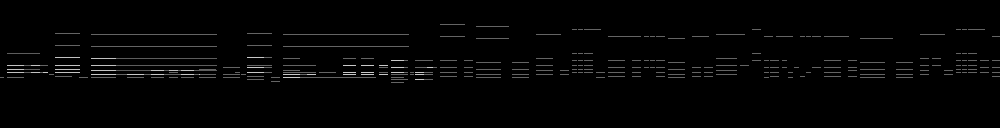

In [37]:
# Of course we have the same problem as before, we'll need to crop a portion of the img to visualize it properly
img = x[0,:,:,1000:2000].sum(dim=0,dtype=torch.uint8).cpu() # need to move it to CPUP for PIL
img = transforms.ToPILImage()(img)
display(img)

### Data Augmentation

So let's assume we want to randomly crop the image. We'll come back to this in a second.

Do we need any other transformation? Do we want to flip them? No, because that's like reversing the song and given that Beatles reversed are the devil's music, we can assume that flipping horizontally will result in a different genre.
Flipping vertically also makes no sense for us as we'd lose pitch informations.

Do we want to resize the image? We could, but one of the dimensions is 128px, so maybe cropping to 128x128 would suffice, without any resizing.

This brings us back to the original transform, cropping. Cropping to 128x128 is not such a bad idea actually, as 128 is a multiple of 8 (which is a bar) so we'd be randomly taking crops of 16 bars of a MIDI file, which does sounds like it might be enough to classify a genre!

( We might want to do [MixUp](https://arxiv.org/abs/1710.09412), but we'll leave it for now.. )

This brings a realization though, we've now moved away from a more temporal-aware model that resembles an NLP model (with a fixed sequence length, padding and Conv1D) in favour of a more vision-like CNN model. Because we want to take a random crop of onty 128 timesteps in the piano rolls, we definitely don't want to take crops in the *padded* part of the "image" and it does make sense to question our design choice of padding at all!

One good thing though is that we probably don't need PIL for this type of transform, we can just subset an array from a random location using torch/numpy.

Let's take a fresh look at the data in our next notebook.

In [ ]:
## For completeness sake let's present here the types of model I'd have implemented if we didn't want to go through with the data augmentation strategy
class PRModelStem(nn.Module):
    """
    Stem of our PianoRoll Network
    The stem of a network is usually the first part, 
    that goes from the inputs to the first hidden layers
    
    The input expected has dimension
        b x i x p x l
    where 
        b = batch size
        i = number of input instruments
        p = number of input pitches
        l = sequence length
    """
    def __init__(self, out_filters, n_pitches=128, n_instruments=5):
        """
        @param out_filters number of desired output filters
        @param n_pitches number of input pitches, default is 128
        @param n_instruments number of input instruments, default is 5
        """
        super(PRModelStem,self).__init__() # init the nn.Module
        self.n_instruments, self.out_filters = n_instruments, out_filters

        # b x i x p x l
        conv_stem = nn.Sequential(
            nn.Conv2d(in_channels=n_instruments, out_channels=128, kernel_size=(12,8), stride=(4,4)), # b x 16 x p' x l'
                # where X' = (X - kernel_size + 2*padding)/stride +1
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(6,6), stride=(2,3)), # b x 32 x p'' x l''
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), stride=(1,2)), # b x 64 x p* x l*
            nn.ReLU()
        )
        # assume b x 5 x 128 x 10000 at the start,
        # we're now to b x 64 x 11 x 207 ... still quite a big image, but not so painful to flatten!
        

    def forward(self,x):
        raise NotImplementedError # we just need to pass x through the conv_stem at this point, 
                                  # but let's not risk implementing a working *useless* model
                

## Model with depthwise separable convolutions

import copy

#Let's define our firs module then
class PR_DWC_ModelStem(nn.Module):
    """
    Stem of our PianoRoll Network
    The stem of a network is usually the first part, 
    that goes from the inputs to the first hidden layers
    """
    def __init__(self, n_pitches, out_filters):
        """
        @param n_pitches number of input pitches
        @param out_filters number of desired output filters
        """
        super(PR_DWC_ModelStem,self).__init__() # init the nn.Module
        self.n_pitches, self.out_filters = n_pitches, out_filters
        
        # remember that, from the docs https://salu133445.github.io/lakh-pianoroll-dataset/dataset
        # In LPD-5, the tracks are merged into five common categories: 
        # Drums, Piano, Guitar, Bass and Strings according to the program numbers provided in the MIDI files
        
        # model for each instrument 
        # each will start from # b x 128 x seq_length
        single_instrument_model = nn.Sequential(
          nn.Conv1d(in_channels=128,out_channels=16,kernel_size=3,stride=2), # b x 16 x ~seq_length/2
          nn.ReLU(),
          nn.Conv1d(in_channels=16,out_channels=32,kernel_size=3,stride=2), # b x 32 x ~seq_length/4
          nn.ReLU(),
          nn.Conv1d(in_channels=32,out_channels=64,kernel_size=3,stride=2), # b x 64 x ~seq_length/8
          nn.ReLU()
        )
        
        # deepcopy for all other instruments
        instruments_stem = single_instrument_model + \
          [ copy.deepcopy(single_instrument_model) for _ in range(4) ]
            
        # "point-wise" convolution
        # we stack the inputs to get b x 5 x 64 x ~seq_length/8
        mixup = nn.Conv2d(in_channels=5,out_channels=64,kernel_size=1) # b x out_filters x 64 x ~seq_length/8
        
        ## we're still handling HUGE TENSORS!!
        
    def forward(self,x):
        raise NotImplementedError # I don't think this model is the way to go, just keep it here to remember it
        